# ECG Heartbeat Categorization - Modeling


### Metric
This is a multiclass classification task so the metric will be *Accuracy.* We will also look at *Precision, Recall/Sensitivity, and Specificity* 

### Algorithms
Non-Deep Learning:
* Decision Tree
* Random Forest
* XGBoost Classifier
    
Neural Network Architectures:
* Single fully connected layer with same number of neurons as the input variables,
     one hidden layer with 512 neurons and softmax output layer.
* Second model with an additional hidden layer of 64 neurons and a dropout layer at (0.2)

Sequence Learning Architecture:
* 1D Convolutional layer with 10 filters, MaxPooling1D, three LSTM's with 100 units each, BatchNormalization, and Dense softmax output layer.

In [1]:
# imports
import numpy as np
import pandas as pd
import os
#!pip install pandas-profiling
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
import graphviz
import joblib
import pickle
%matplotlib inline

np.random.seed(123)

#!pip install scikit-learn
import sklearn
import scikitplot as skplt
import sklearn.feature_selection
from sklearn.preprocessing import label_binarize,OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



## Load Data

In [82]:
# Sampled dataset
data_ecg = pd.read_csv('data_ecg.csv')
data_ecg.head(3)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
#Split features and targets and make copy of df
X = data_ecg.drop('label',axis=1).copy() 
y = data_ecg['label'].copy()

In [84]:
import imblearn
from collections import Counter
print(imblearn.__version__)
counter = Counter(y)
print(counter)

0.7.0
Counter({0.0: 72470, 4.0: 6431, 2.0: 5788, 1.0: 2223, 3.0: 641})


In [85]:
#Class distributions
import matplotlib.pyplot as pyplot
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=72470 (82.773%)
Class=1, n=2223 (2.539%)
Class=2, n=5788 (6.611%)
Class=3, n=641 (0.732%)
Class=4, n=6431 (7.345%)


## Balance the dataset
* Random Undersampling
* SMOTE

In [86]:
#SMOTE
# label encode the target variable
y = LabelEncoder().fit_transform(y)

# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=72470 (20.000%)
Class=1, n=72470 (20.000%)
Class=2, n=72470 (20.000%)
Class=3, n=72470 (20.000%)
Class=4, n=72470 (20.000%)


Class=0, n=50000 (14.711%)
Class=1, n=72470 (21.322%)
Class=2, n=72470 (21.322%)
Class=3, n=72470 (21.322%)
Class=4, n=72470 (21.322%)


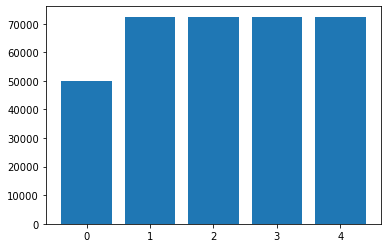

In [87]:
# Random Undersampling

from imblearn.under_sampling import RandomUnderSampler

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy= {0:50000})

# transform the dataset
X, y = undersample.fit_resample(X, y)

# summarize class distribution
#print(Counter(y))



# summarize class distribution

counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [88]:
X.shape

(339880, 187)

In [89]:
y.shape

(339880,)

## Train -Test Split and PCA

#### Scaling / Normalizing / Centering
Note: Dataset is already scaled between 0 and 1 - may want to experiment here

Note: Fitting must be done on the training data to avoid 'leaking' from test data.

In [90]:
# Using 90% for training and 10% for testing
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y,train_size=0.9,random_state=0)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [91]:
X_train.shape

(305892, 187)

In [92]:
X_test.shape

(33988, 187)

## PCA

In [60]:
from sklearn.decomposition import PCA

#Make an instance of the Model using 95% variance (.95)
pca = PCA(.95)#.83 gives 10 PCA

In [61]:
#Fit PCA on training set
pca.fit(X_train)

PCA(n_components=0.95)

In [62]:
pca.n_components_

28

In [63]:
#Apply the mapping (transform) to both the training set and the test set
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [64]:
X_test.shape

(33988, 28)

In [65]:
X_train.shape

(305892, 28)

## Class Labels

In [93]:
# For class label mapping

class_label = {
    0: 'N - Normal',
    1: 'S - Atrial premature',
    2: 'V - Premature ventricular contraction',
    3: 'F - Fusion of ventricular and normal',
    4: 'Q - Paced Unclassifiable'
}

# Model Definition and Training

## Decision Tree (Imbalanced and no PCA)

In [10]:
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
pred_dt = dt.predict(X_test)
pred2 = dt.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_dt)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_dt)))

Accuracy on train: 1.000
Accuracy on test: 0.955
Confusion Matrix:
[[7120   67   66   28   27]
 [  55  130    8    1    2]
 [  70    3  497    2    6]
 [  13    0    6   31    1]
 [  30    1    5    1  586]]


In [11]:
print("dt:",classification_report(y_test, pred_dt))

dt:               precision    recall  f1-score   support

           0       0.98      0.97      0.98      7308
           1       0.65      0.66      0.65       196
           2       0.85      0.86      0.86       578
           3       0.49      0.61      0.54        51
           4       0.94      0.94      0.94       623

    accuracy                           0.96      8756
   macro avg       0.78      0.81      0.79      8756
weighted avg       0.96      0.96      0.96      8756



Text(0.5, 15.0, 'Predicted Class')

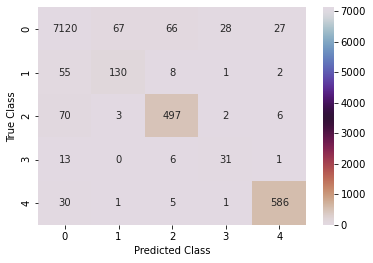

In [12]:
cm = confusion_matrix(y_test,pred_dt)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight_r')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [13]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.8839779  0.99170561 0.98960626 0.99632395 0.99557359]
Specificity Mean: 0.9714374619123891
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.97427477 0.66326531 0.85986159 0.60784314 0.94060995]
Recall/Sensitivity Mean: 0.809170950859395
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.97694841 0.64676617 0.85395189 0.49206349 0.94212219]
Precision Mean: 0.7823704292179486


## ROC scores

In [14]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = dt.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.880732 (macro),
0.891463 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.890304 (macro),
0.928594 (weighted by prevalence)


## ROC plot

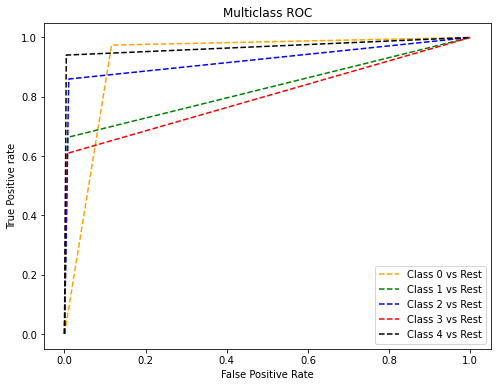

In [15]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = dt.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict and plot an example

The predicted class of the ECG Sample is: 2
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


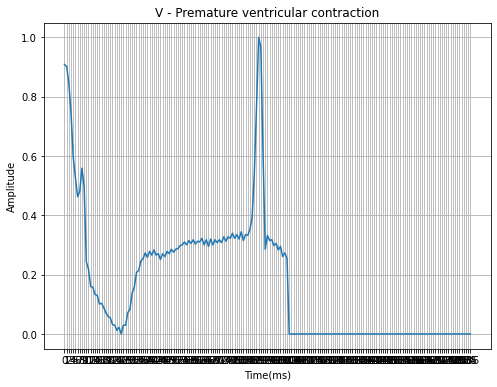

In [16]:
# Predict and plot example 
print('The predicted class of the ECG Sample is:', pred_dt[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

## Decision Tree (Balanced no PCA)

In [94]:
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
pred_dt = dt.predict(X_test)
pred2 = dt.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_dt)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_dt)))

Accuracy on train: 1.000
Accuracy on test: 0.984
Confusion Matrix:
[[4729  156   75   43   38]
 [  57 7195   12    6    2]
 [  55   14 7236   11   15]
 [  16    2    8 7118    2]
 [  26    4    7    2 7159]]


In [95]:
print("dt:",classification_report(y_test, pred_dt))

dt:               precision    recall  f1-score   support

           0       0.97      0.94      0.95      5041
           1       0.98      0.99      0.98      7272
           2       0.99      0.99      0.99      7331
           3       0.99      1.00      0.99      7146
           4       0.99      0.99      0.99      7198

    accuracy                           0.98     33988
   macro avg       0.98      0.98      0.98     33988
weighted avg       0.98      0.98      0.98     33988



Text(0.5, 15.0, 'Predicted Class')

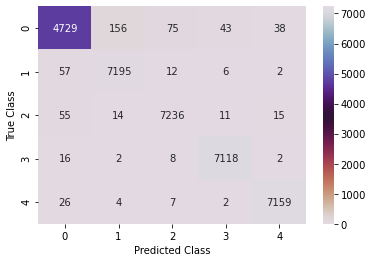

In [96]:
cm = confusion_matrix(y_test,pred_dt)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight_r')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [97]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.99467993 0.99341219 0.99617361 0.99769019 0.99787234]
Specificity Mean: 0.9959656520247643
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.93810752 0.98941144 0.98704133 0.99608172 0.99458183]
Recall/Sensitivity Mean: 0.9810447686306804
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.96846201 0.97612264 0.98609975 0.9913649  0.99210089]
Precision Mean: 0.9828300395949124


## ROC scores

In [98]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = dt.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.988153 (macro),
0.988845 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.988505 (macro),
0.989914 (weighted by prevalence)


## ROC plot

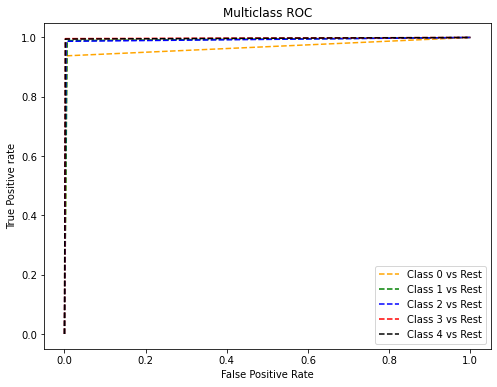

In [99]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = dt.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict and plot an example

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


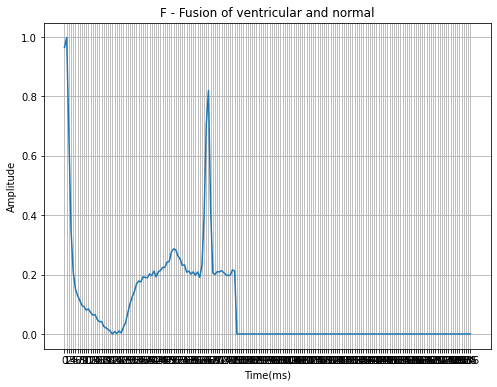

In [100]:
# Predict and plot example
prediction_cplx = dt.predict(X_test)
print('The predicted class of the ECG sample is:', prediction_cplx[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.title(Classes)
plt.grid()
plt.show()

## Decision Tree (Balanced and with PCA)

In [67]:
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
pred_dt = dt.predict(X_test)
pred2 = dt.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_dt)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_dt)))

Accuracy on train: 1.000
Accuracy on test: 0.980
Confusion Matrix:
[[4648  176  113   41   63]
 [  74 7185    8    3    2]
 [  57   19 7221   23   11]
 [  14    0   17 7115    0]
 [  21    4   17    7 7149]]


In [68]:
print("dt:",classification_report(y_test, pred_dt))

dt:               precision    recall  f1-score   support

           0       0.97      0.92      0.94      5041
           1       0.97      0.99      0.98      7272
           2       0.98      0.98      0.98      7331
           3       0.99      1.00      0.99      7146
           4       0.99      0.99      0.99      7198

    accuracy                           0.98     33988
   macro avg       0.98      0.98      0.98     33988
weighted avg       0.98      0.98      0.98     33988



Text(0.5, 15.0, 'Predicted Class')

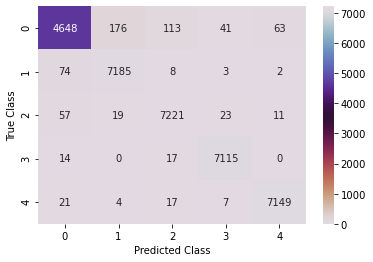

In [69]:
cm = confusion_matrix(y_test,pred_dt)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight_r')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [70]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.99426538 0.99255128 0.99418539 0.99724313 0.99716312]
Specificity Mean: 0.9950816601813681
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.92203928 0.9880363  0.98499523 0.99566191 0.99319255]
Recall/Sensitivity Mean: 0.9767850539104568
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.96551724 0.97304984 0.9789859  0.9897065  0.98948097]
Precision Mean: 0.9793480887952859


## ROC scores

In [71]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = dt.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.985491 (macro),
0.986360 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.985933 (macro),
0.987704 (weighted by prevalence)


## ROC plot

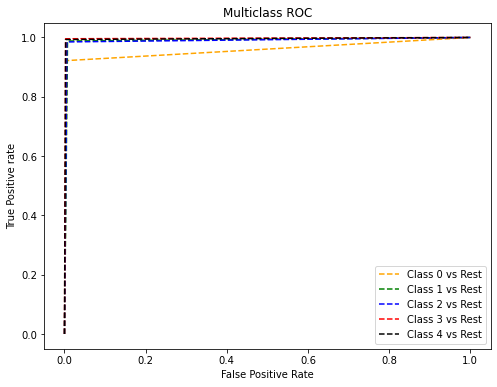

In [72]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = dt.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict and plot an example

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


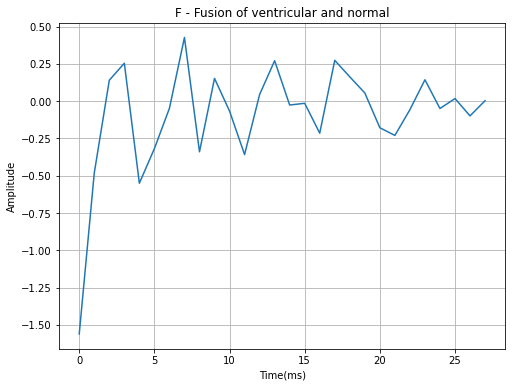

In [73]:
# Predict and plot example
prediction_cplx = dt.predict(X_test)
print('The predicted class of the ECG sample is:', prediction_cplx[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.title(Classes)
plt.grid()
plt.show()

## Random Forest Classifier (Imbalanced and no PCA)

In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1,criterion='gini')# removed , oob_score=True for too few estimators
rf.fit(X_train,y_train)
pred_rf= rf.predict(X_test)
pred2= rf.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_rf)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_rf)))

Accuracy on train: 0.997
Accuracy on test: 0.975
Confusion Matrix:
[[7289    2   11    3    3]
 [  60  133    3    0    0]
 [  75    1  501    0    1]
 [  20    0    6   25    0]
 [  27    1    3    0  592]]


In [18]:
print("rf:",classification_report(y_test, pred_rf))

rf:               precision    recall  f1-score   support

           0       0.98      1.00      0.99      7308
           1       0.97      0.68      0.80       196
           2       0.96      0.87      0.91       578
           3       0.89      0.49      0.63        51
           4       0.99      0.95      0.97       623

    accuracy                           0.98      8756
   macro avg       0.96      0.80      0.86      8756
weighted avg       0.98      0.98      0.97      8756



Text(0.5, 15.0, 'Predicted Class')

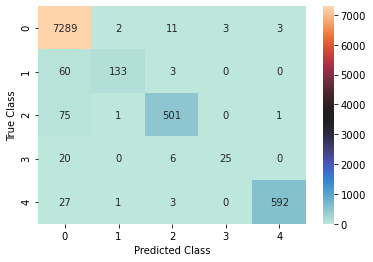

In [19]:
cm = confusion_matrix(y_test,pred_rf)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='icefire')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [20]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.87430939 0.99953271 0.99718758 0.99965537 0.99950818]
Specificity Mean: 0.9740386452022944
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.99740011 0.67857143 0.86678201 0.49019608 0.95024077]
Recall/Sensitivity Mean: 0.7966380787715562
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.97563914 0.97080292 0.95610687 0.89285714 0.99328859]
Precision Mean: 0.9577389322796949


# ROC Scores

In [21]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = rf.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.968180 (macro),
0.974687 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.973008 (macro),
0.989729 (weighted by prevalence)


# ROC Plot

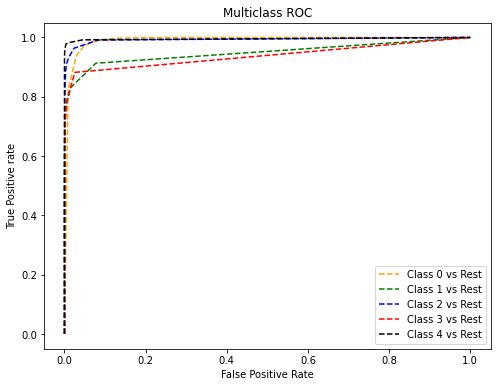

In [22]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = rf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict and plot an example

The predicted class of the ECG Sample is: 2
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


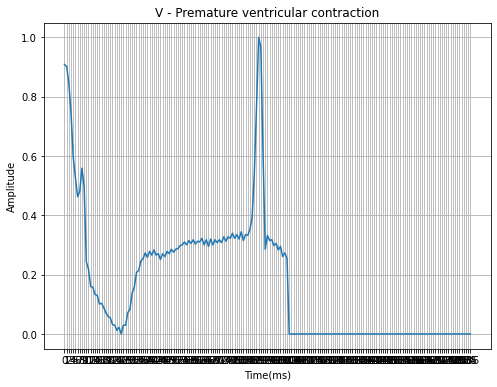

In [23]:
# Predict and plot example 
print('The predicted class of the ECG Sample is:', pred_rf[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

## Random Forest Classifier (Balanced and no PCA)

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1,criterion='gini')
rf.fit(X_train,y_train)
pred_rf= rf.predict(X_test)
pred2= rf.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_rf)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_rf)))

Accuracy on train: 1.000
Accuracy on test: 0.996
Confusion Matrix:
[[4960   34   22   13   12]
 [  24 7244    4    0    0]
 [  15    1 7310    3    2]
 [   0    0    2 7144    0]
 [  10    2    1    2 7183]]


In [43]:
print("rf:",classification_report(y_test, pred_rf))

rf:               precision    recall  f1-score   support

           0       0.99      0.98      0.99      5041
           1       0.99      1.00      1.00      7272
           2       1.00      1.00      1.00      7331
           3       1.00      1.00      1.00      7146
           4       1.00      1.00      1.00      7198

    accuracy                           1.00     33988
   macro avg       1.00      0.99      1.00     33988
weighted avg       1.00      1.00      1.00     33988



Text(0.5, 15.0, 'Predicted Class')

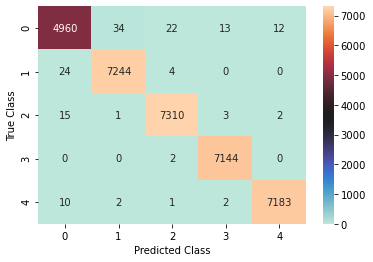

In [44]:
cm = confusion_matrix(y_test,pred_rf)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='icefire')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [45]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.99830725 0.99861506 0.99891211 0.99932941 0.99947742]
Specificity Mean: 0.9989282490076201
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.98393176 0.99614961 0.99713545 0.99972012 0.99791609]
Recall/Sensitivity Mean: 0.994970607534065
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.99021761 0.99491828 0.99604851 0.99748674 0.99805475]
Precision Mean: 0.9953451754627055


## ROC scores

In [46]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = rf.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.999849 (macro),
0.999859 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999852 (macro),
0.999875 (weighted by prevalence)


## ROC plot

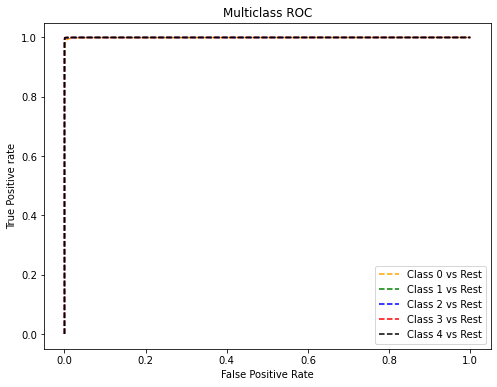

In [47]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = rf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict and plot example

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


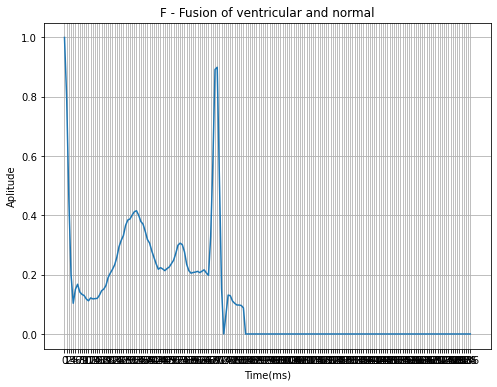

In [48]:
# Predict and plot example
print('The predicted class of the ECG sample is:', pred_rf[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Aplitude')
plt.xlabel('Time(ms)')#Note: Time(187(ms))without pca
plt.grid()
plt.show()

## Random Forest Classifier (Balanced and with PCA)

In [74]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,n_jobs=-1,criterion='gini')# removed , oob_score=True for too few estimators
rf.fit(X_train,y_train)
pred_rf= rf.predict(X_test)
pred2= rf.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_rf)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(y_test,pred_rf)))

Accuracy on train: 1.000
Accuracy on test: 0.995
Confusion Matrix:
[[4934   50   36   14    7]
 [  21 7249    1    0    1]
 [  21    1 7305    3    1]
 [   0    0    1 7145    0]
 [  10    1    2    0 7185]]


In [75]:
print("rf:",classification_report(y_test, pred_rf))

rf:               precision    recall  f1-score   support

           0       0.99      0.98      0.98      5041
           1       0.99      1.00      0.99      7272
           2       0.99      1.00      1.00      7331
           3       1.00      1.00      1.00      7146
           4       1.00      1.00      1.00      7198

    accuracy                           0.99     33988
   macro avg       0.99      0.99      0.99     33988
weighted avg       0.99      0.99      0.99     33988



Text(0.5, 15.0, 'Predicted Class')

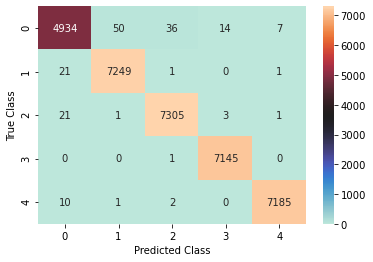

In [76]:
cm = confusion_matrix(y_test,pred_rf)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='icefire')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [77]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.99820361 0.9980536  0.99849946 0.99936666 0.99966405]
Specificity Mean: 0.9987574776652399
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.97877405 0.99683718 0.99645342 0.99986006 0.99819394]
Recall/Sensitivity Mean: 0.9940237315633567
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.9895708  0.99287769 0.99455412 0.99762636 0.99874896]
Precision Mean: 0.994675584697412


## ROC scores

In [78]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = rf.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.999799 (macro),
0.999817 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999807 (macro),
0.999847 (weighted by prevalence)


## ROC plot

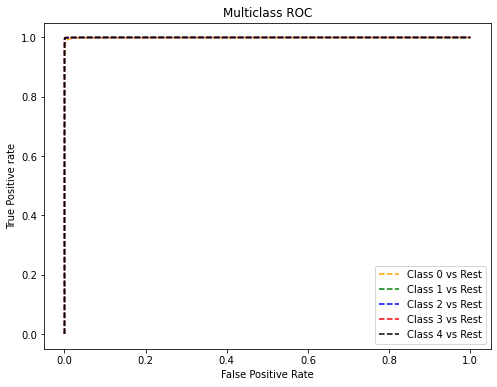

In [79]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = rf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict and plot example

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


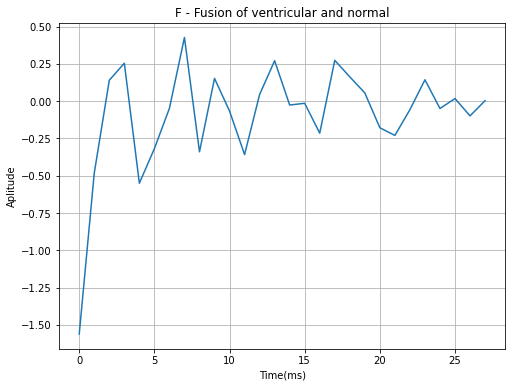

In [80]:
# Predict and plot example
print('The predicted class of the ECG sample is:', pred_rf[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Aplitude')
plt.xlabel('Time(ms)')#Note: Time(187(ms))without pca
plt.grid()
plt.show()

## XGBoost (Imbalanced and no PCA)

In [121]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=5,n_jobs=-1,booster = "gbtree",num_class = 5,
                    eval_metric = "mlogloss",objective = "multi:softprob")
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
pred2 = xgb.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_xgb)))
print('\n{}'.format(confusion_matrix(y_test,pred_xgb)))

Accuracy on train: 0.980
Accuracy on test: 0.974

[[7283    4   16    0    5]
 [  62  133    1    0    0]
 [  86    0  491    1    0]
 [  15    0    3   33    0]
 [  34    0    2    1  586]]


In [122]:
print("xgb:",classification_report(y_test, pred_xgb))

xgb:               precision    recall  f1-score   support

           0       0.97      1.00      0.98      7308
           1       0.97      0.68      0.80       196
           2       0.96      0.85      0.90       578
           3       0.94      0.65      0.77        51
           4       0.99      0.94      0.97       623

    accuracy                           0.97      8756
   macro avg       0.97      0.82      0.88      8756
weighted avg       0.97      0.97      0.97      8756



Text(0.5, 15.0, 'Predicted Class')

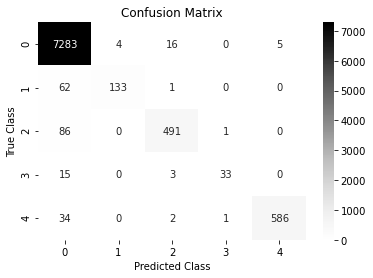

In [123]:
cm = confusion_matrix(y_test,pred_xgb)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='Greys')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [124]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.86395028 0.99953271 0.99730986 0.99977025 0.99938522]
Specificity Mean: 0.9719896619848336
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.99657909 0.67857143 0.84948097 0.64705882 0.94060995]
Recall/Sensitivity Mean: 0.8224600528423112
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.9736631  0.97080292 0.95711501 0.94285714 0.99153976]
Precision Mean: 0.9671955874058813


### ROC for multi-class classification model (Imbalanced and no PCA)

In [125]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = xgb.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.988520 (macro),
0.988730 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.991397 (macro),
0.993621 (weighted by prevalence)


### ROC plot

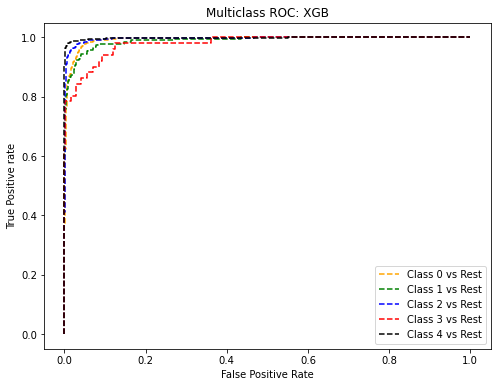

In [126]:
#ROC for multi-class classification model, Imbalanced data 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = xgb.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 2
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


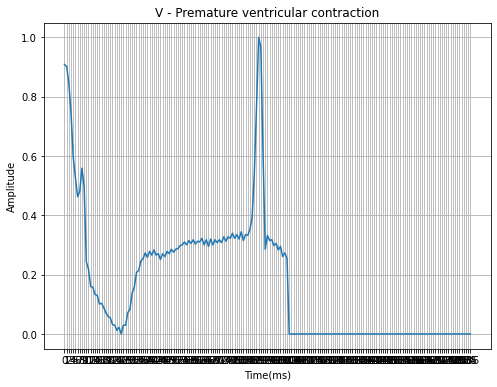

In [127]:
# Predict and plot example
print('The predicted class of the ECG sample is:', pred_xgb[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

## XGBoost (Balanced and no PCA)

In [37]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=5,n_jobs=-1,booster = "gbtree",num_class = 5,
                    eval_metric = "mlogloss",objective = "multi:softprob")
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
pred2 = xgb.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_xgb)))
print('\n{}'.format(confusion_matrix(y_test,pred_xgb)))

Accuracy on train: 0.968
Accuracy on test: 0.964

[[4521  221   96  154   49]
 [ 241 6972   28   26    5]
 [ 100   16 7090  104   21]
 [  43   11   35 7056    1]
 [  34   11   23    6 7124]]


In [38]:
print("xgb:",classification_report(y_test, pred_xgb))

xgb:               precision    recall  f1-score   support

           0       0.92      0.90      0.91      5041
           1       0.96      0.96      0.96      7272
           2       0.97      0.97      0.97      7331
           3       0.96      0.99      0.97      7146
           4       0.99      0.99      0.99      7198

    accuracy                           0.96     33988
   macro avg       0.96      0.96      0.96     33988
weighted avg       0.96      0.96      0.96     33988



Text(0.5, 15.0, 'Predicted Class')

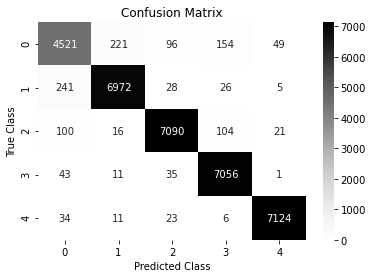

In [39]:
cm = confusion_matrix(y_test,pred_xgb)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='Greys')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [40]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.98555982 0.99030543 0.99317253 0.98919604 0.99716312]
Specificity Mean: 0.9910793865663567
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.89684586 0.95874587 0.9671259  0.98740554 0.98971937]
Recall/Sensitivity Mean: 0.9599685100504768
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.91536748 0.96418199 0.9749725  0.96052273 0.98944444]
Precision Mean: 0.960897830528489


### ROC for multi-class classification model

In [41]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = xgb.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.997750 (macro),
0.997929 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.997901 (macro),
0.998193 (weighted by prevalence)


### ROC plot

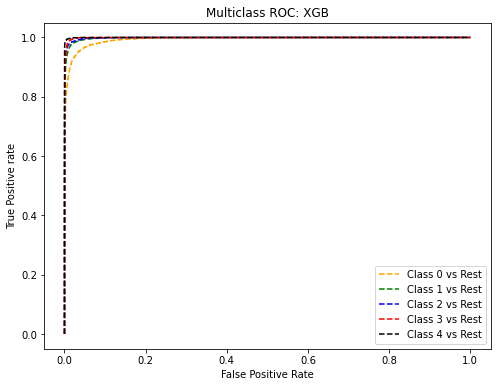

In [42]:
#ROC for multi-class classification model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = xgb.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC: XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


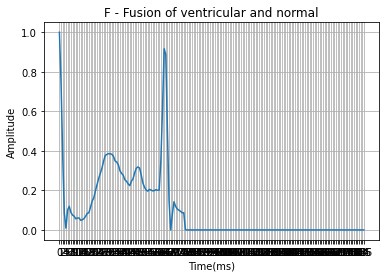

In [45]:
# Predict and plot example
print('The predicted class of the ECG sample is:', pred_xgb[8])
print('Class:',class_label)

#plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

## XGBoost (Balanced and with PCA)

In [152]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=5,n_jobs=-1,booster = "gbtree",num_class = 5,
                    eval_metric = "mlogloss",objective = "multi:softprob")
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
pred2 = xgb.predict(X_train)
print("Accuracy on train: {:.3f}".format(accuracy_score(y_train,pred2)))
print("Accuracy on test: {:.3f}".format(accuracy_score(y_test,pred_xgb)))
print('\n{}'.format(confusion_matrix(y_test,pred_xgb)))

Accuracy on train: 0.953
Accuracy on test: 0.945

[[4277  319  199  187   59]
 [ 357 6829   56   23    7]
 [  99   41 6967  163   61]
 [  34   46   75 6982    9]
 [  53   13   67    9 7056]]


In [153]:
print("xgb:",classification_report(y_test, pred_xgb))

xgb:               precision    recall  f1-score   support

           0       0.89      0.85      0.87      5041
           1       0.94      0.94      0.94      7272
           2       0.95      0.95      0.95      7331
           3       0.95      0.98      0.96      7146
           4       0.98      0.98      0.98      7198

    accuracy                           0.94     33988
   macro avg       0.94      0.94      0.94     33988
weighted avg       0.94      0.94      0.94     33988



Text(0.5, 15.0, 'Predicted Class')

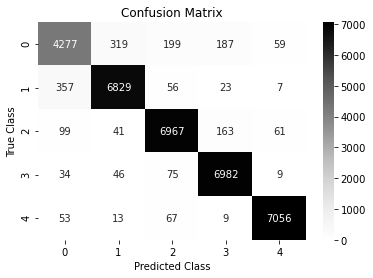

In [154]:
cm = confusion_matrix(y_test,pred_xgb)
#sns.heatmap(cm, annot=True)
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='Greys')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [155]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.98124158 0.98431651 0.9851071  0.98576857 0.99492348]
Specificity Mean: 0.9862714491524566
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.84844277 0.93908141 0.95034784 0.9770501  0.9802723 ]
Recall/Sensitivity Mean: 0.939038882239695
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.8873444  0.94219095 0.94608908 0.94812602 0.9810901 ]
Precision Mean: 0.9409681096335444


### ROC for multi-class classification model

In [156]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = xgb.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test,prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.995216 (macro),
0.995555 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.995499 (macro),
0.996056 (weighted by prevalence)


### ROC plot

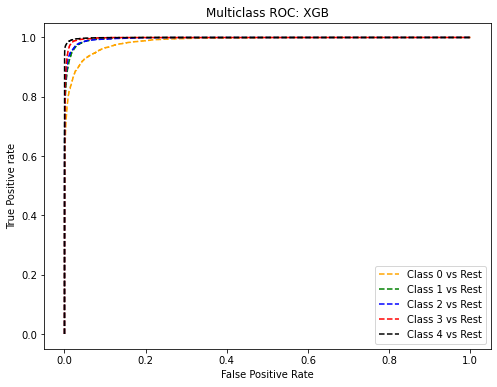

In [157]:
#ROC for multi-class classification model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = xgb.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)#might have to use proba

#y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])  



    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass ROC: XGB')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 2
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


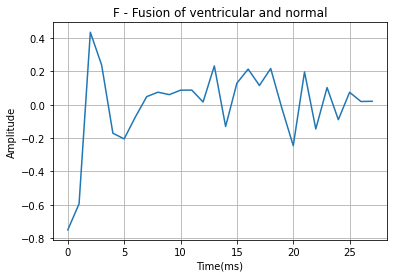

In [197]:
# Predict and plot example
print('The predicted class of the ECG sample is:', pred_xgb[8])
print('Class:',class_label)

#plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

### Note: The above prediction is incorrect

# Neural Network
### Baseline NN 

In [94]:
import tensorflow as tf
import keras
from keras.utils import plot_model
from keras import regularizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Conv1D,MaxPooling1D,AveragePooling1D,MaxPooling2D,AveragePooling2D
from keras.models import Sequential, load_model
from keras.utils.np_utils import to_categorical
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import SeparableConv2D
from keras.layers.core import Activation
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [95]:
X_train.shape

(305892, 187)

In [96]:
X_test.shape

(33988, 187)

In [97]:
y_train.shape

(305892,)

In [98]:
y_test.shape

(33988,)

In [99]:
n_cols = X_train.shape[1]
n_cols

187

## Baseline Neural Network (Imbalanced and no PCA)

In [57]:
batch_size = 320 #850
num_classes = 5 
epochs = 10

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(512, input_dim=(n_cols), activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

model = create_baseline()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               96256     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 98,821
Trainable params: 98,821
Non-trainable params: 0
_________________________________________________________________


In [58]:
# evaluate model
estimator = KerasClassifier(build_fn=create_baseline, 
                            epochs=epochs, batch_size=batch_size, 
                           verbose=1)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

Epoch 1/10
59097/59097 [==============================] - 2s 37us/step - loss: 0.4212 - accuracy: 0.8870
Epoch 2/10
59097/59097 [==============================] - 2s 30us/step - loss: 0.2402 - accuracy: 0.9327
Epoch 3/10
59097/59097 [==============================] - 2s 32us/step - loss: 0.1963 - accuracy: 0.9465
Epoch 4/10
59097/59097 [==============================] - 2s 38us/step - loss: 0.1757 - accuracy: 0.9518
Epoch 5/10
59097/59097 [==============================] - 2s 38us/step - loss: 0.1575 - accuracy: 0.9570
Epoch 6/10
59097/59097 [==============================] - 2s 40us/step - loss: 0.1457 - accuracy: 0.9599
Epoch 7/10
59097/59097 [==============================] - 2s 37us/step - loss: 0.1356 - accuracy: 0.9623
Epoch 8/10
59097/59097 [==============================] - 2s 36us/step - loss: 0.1273 - accuracy: 0.9635
Epoch 9/10
59097/59097 [==============================] - 2s 36us/step - loss: 0.1198 - accuracy: 0.9660
Epoch 10/10
19700/19700 [==============================

In [59]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 96.60% (0.15%)


In [60]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    validation_data= (X_test,y_test))

Train on 78797 samples, validate on 8756 samples
Epoch 1/10
 - 2s - loss: 0.3985 - accuracy: 0.8913 - val_loss: 0.2470 - val_accuracy: 0.9307
Epoch 2/10
 - 2s - loss: 0.2255 - accuracy: 0.9369 - val_loss: 0.1847 - val_accuracy: 0.9489
Epoch 3/10
 - 3s - loss: 0.1813 - accuracy: 0.9509 - val_loss: 0.1584 - val_accuracy: 0.9569
Epoch 4/10
 - 3s - loss: 0.1570 - accuracy: 0.9574 - val_loss: 0.1461 - val_accuracy: 0.9592
Epoch 5/10
 - 3s - loss: 0.1410 - accuracy: 0.9615 - val_loss: 0.1301 - val_accuracy: 0.9651
Epoch 6/10
 - 3s - loss: 0.1290 - accuracy: 0.9642 - val_loss: 0.1297 - val_accuracy: 0.9669
Epoch 7/10
 - 3s - loss: 0.1194 - accuracy: 0.9667 - val_loss: 0.1101 - val_accuracy: 0.9703
Epoch 8/10
 - 3s - loss: 0.1118 - accuracy: 0.9685 - val_loss: 0.1087 - val_accuracy: 0.9718
Epoch 9/10
 - 3s - loss: 0.1053 - accuracy: 0.9704 - val_loss: 0.1071 - val_accuracy: 0.9741
Epoch 10/10
 - 3s - loss: 0.1004 - accuracy: 0.9718 - val_loss: 0.1018 - val_accuracy: 0.9744


In [61]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)    
prediction_bl = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               96256     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 98,821
Trainable params: 98,821
Non-trainable params: 0
_________________________________________________________________
None
train samples: 78797
test samples: 8756
Test loss: 0.10180375774724128
Test accuracy: 0.9744175672531128


In [62]:
print(classification_report(y_test.astype(int), prediction_bl))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7308
           1       0.88      0.69      0.78       196
           2       0.92      0.90      0.91       578
           3       0.91      0.61      0.73        51
           4       0.98      0.96      0.97       623

    accuracy                           0.97      8756
   macro avg       0.93      0.83      0.87      8756
weighted avg       0.97      0.97      0.97      8756



Text(0.5, 15.0, 'Predicted Class')

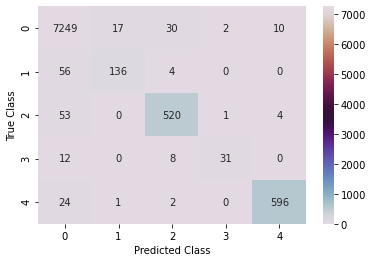

In [63]:
cm = confusion_matrix(y_test,prediction_bl)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [64]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.89986188 0.9978972  0.99461971 0.99965537 0.99827862]
Specificity Mean: 0.978062554917698
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.99192666 0.69387755 0.89965398 0.60784314 0.95666132]
Recall/Sensitivity Mean: 0.8299925278891405
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.98038951 0.88311688 0.92198582 0.91176471 0.97704918]
Precision Mean: 0.9348612179867997


## Visualize training and test histories

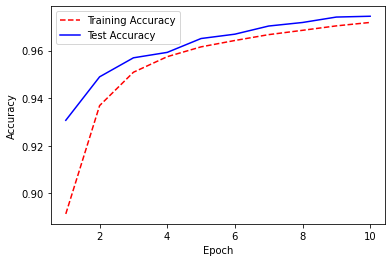

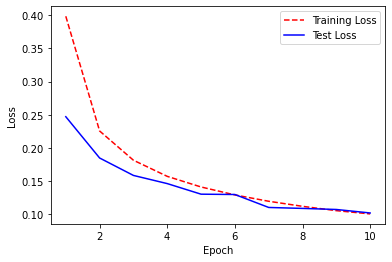

In [65]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification NN

In [66]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.985431 (macro),
0.984897 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.987618 (macro),
0.990439 (weighted by prevalence)


## ROC Plot

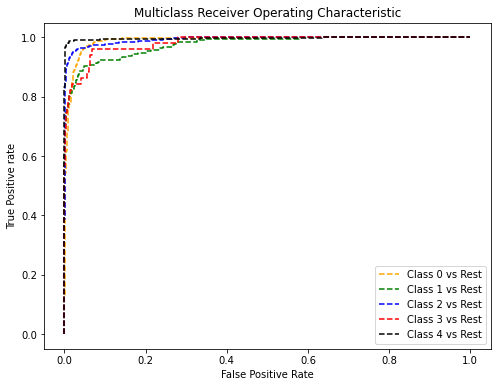

In [67]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 2
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


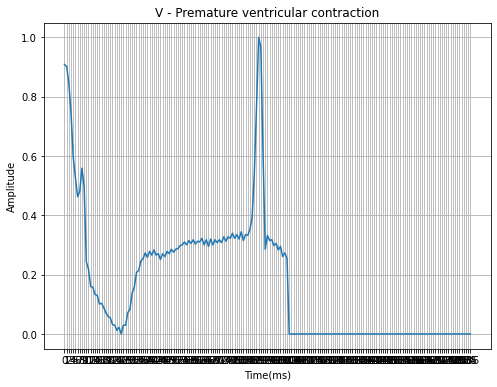

In [81]:
# Predict and plot example
print('The predicted class of the ECG sample is:', prediction_bl[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

## Baseline Neural Network (Balanced and no PCA)

In [100]:
batch_size = 320 #850
num_classes = 5 
epochs = 10

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(512, input_dim=(n_cols), activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

model = create_baseline()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               96256     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 98,821
Trainable params: 98,821
Non-trainable params: 0
_________________________________________________________________


In [54]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, 
                            epochs=epochs, batch_size=batch_size, 
                           verbose=1)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

Epoch 1/10
229419/229419 [==============================] - 7s 32us/step - loss: 0.4224 - accuracy: 0.8516
Epoch 2/10
229419/229419 [==============================] - 7s 31us/step - loss: 0.2125 - accuracy: 0.9271
Epoch 3/10
229419/229419 [==============================] - 7s 32us/step - loss: 0.1567 - accuracy: 0.9485
Epoch 4/10
229419/229419 [==============================] - 7s 32us/step - loss: 0.1272 - accuracy: 0.9597
Epoch 5/10
229419/229419 [==============================] - 8s 36us/step - loss: 0.1068 - accuracy: 0.9671
Epoch 6/10
229419/229419 [==============================] - 9s 37us/step - loss: 0.0929 - accuracy: 0.9718
Epoch 7/10
229419/229419 [==============================] - 9s 39us/step - loss: 0.0811 - accuracy: 0.9761
Epoch 8/10
229419/229419 [==============================] - 9s 38us/step - loss: 0.0727 - accuracy: 0.9784 0s - loss: 0.0731 - ac
Epoch 9/10
229419/229419 [==============================] - 9s 38us/step - loss: 0.0643 - accuracy: 0.9815
Epoch 10/10
76

In [55]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 98.01% (0.22%)


In [101]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    validation_data= (X_test,y_test))

Train on 305892 samples, validate on 33988 samples
Epoch 1/10
 - 12s - loss: 0.3827 - accuracy: 0.8657 - val_loss: 0.2388 - val_accuracy: 0.9161
Epoch 2/10
 - 12s - loss: 0.1900 - accuracy: 0.9353 - val_loss: 0.1643 - val_accuracy: 0.9437
Epoch 3/10
 - 11s - loss: 0.1395 - accuracy: 0.9546 - val_loss: 0.1223 - val_accuracy: 0.9622
Epoch 4/10
 - 11s - loss: 0.1104 - accuracy: 0.9657 - val_loss: 0.1016 - val_accuracy: 0.9682
Epoch 5/10
 - 11s - loss: 0.0929 - accuracy: 0.9715 - val_loss: 0.0875 - val_accuracy: 0.9748
Epoch 6/10
 - 12s - loss: 0.0782 - accuracy: 0.9765 - val_loss: 0.0760 - val_accuracy: 0.9773
Epoch 7/10
 - 12s - loss: 0.0688 - accuracy: 0.9798 - val_loss: 0.0682 - val_accuracy: 0.9786
Epoch 8/10
 - 12s - loss: 0.0605 - accuracy: 0.9823 - val_loss: 0.0625 - val_accuracy: 0.9803
Epoch 9/10
 - 12s - loss: 0.0549 - accuracy: 0.9840 - val_loss: 0.0613 - val_accuracy: 0.9806
Epoch 10/10
 - 12s - loss: 0.0487 - accuracy: 0.9860 - val_loss: 0.0522 - val_accuracy: 0.9837


In [102]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)    
prediction_bl = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               96256     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 98,821
Trainable params: 98,821
Non-trainable params: 0
_________________________________________________________________
None
train samples: 305892
test samples: 33988
Test loss: 0.05215819930455576
Test accuracy: 0.983700156211853


In [103]:
print(classification_report(y_test.astype(int), prediction_bl))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      5041
           1       0.97      1.00      0.98      7272
           2       0.99      0.98      0.99      7331
           3       0.98      1.00      0.99      7146
           4       1.00      1.00      1.00      7198

    accuracy                           0.98     33988
   macro avg       0.98      0.98      0.98     33988
weighted avg       0.98      0.98      0.98     33988



Text(0.5, 15.0, 'Predicted Class')

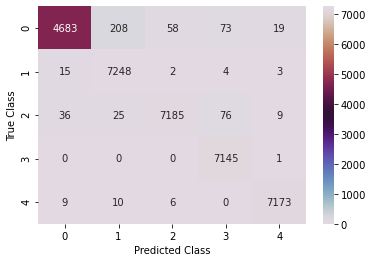

In [104]:
cm = confusion_matrix(y_test,prediction_bl)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [105]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.99792725 0.99090433 0.9975241  0.99429998 0.99880552]
Specificity Mean: 0.9958922355850749
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.92898234 0.99669967 0.98008457 0.99986006 0.99652681]
Recall/Sensitivity Mean: 0.9804306923360626
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.98734978 0.96756107 0.99089781 0.97903535 0.99555864]
Precision Mean: 0.9840805302185605


## Visualize training and test histories

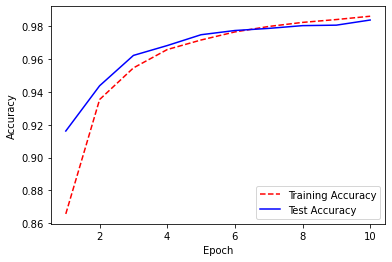

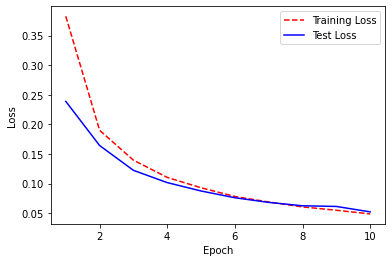

In [106]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification NN

In [107]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.999369 (macro),
0.999420 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999403 (macro),
0.999497 (weighted by prevalence)


## ROC Plot

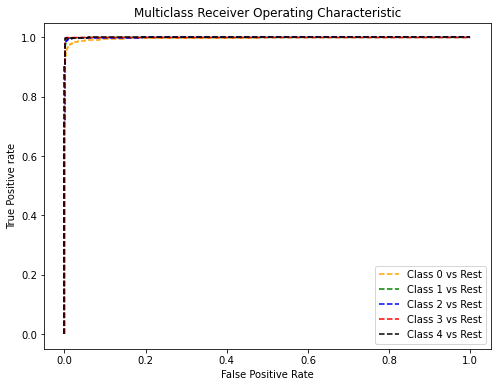

In [108]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


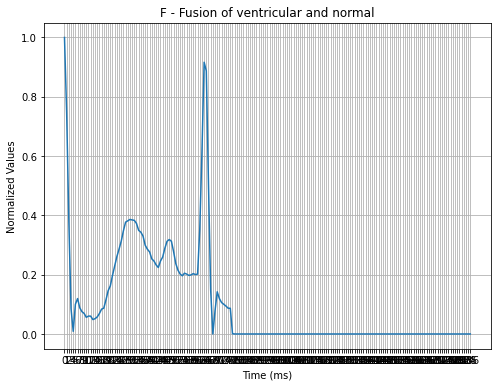

In [109]:
# Predict and plot example
print('The predicted class of the ECG sample is:', prediction_bl[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Normalized Values')
plt.xlabel('Time (ms)')
plt.grid()
plt.show()

## Baseline Neural Network (Balanced and with PCA)

In [205]:
batch_size = 320 #850
num_classes = 5 
epochs = 10

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(512, input_dim=(n_cols), activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

model = create_baseline()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 2565      
Total params: 17,413
Trainable params: 17,413
Non-trainable params: 0
_________________________________________________________________


In [206]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, 
                            epochs=epochs, batch_size=batch_size, 
                           verbose=1)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

Epoch 1/10
229419/229419 [==============================] - 3s 14us/step - loss: 0.4099 - accuracy: 0.8560
Epoch 2/10
229419/229419 [==============================] - 3s 13us/step - loss: 0.2077 - accuracy: 0.9305
Epoch 3/10
229419/229419 [==============================] - 3s 14us/step - loss: 0.1574 - accuracy: 0.9489
Epoch 4/10
229419/229419 [==============================] - 3s 15us/step - loss: 0.1291 - accuracy: 0.9587
Epoch 5/10
229419/229419 [==============================] - 4s 15us/step - loss: 0.1104 - accuracy: 0.9651 0s - loss: 0.1
Epoch 6/10
229419/229419 [==============================] - 4s 16us/step - loss: 0.0968 - accuracy: 0.9699
Epoch 7/10
229419/229419 [==============================] - 4s 16us/step - loss: 0.0865 - accuracy: 0.9733
Epoch 8/10
229419/229419 [==============================] - 3s 15us/step - loss: 0.0778 - accuracy: 0.9765
Epoch 9/10
229419/229419 [==============================] - 3s 15us/step - loss: 0.0709 - accuracy: 0.9789
Epoch 10/10
76473/7647

In [207]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 98.11% (0.05%)


In [208]:
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    validation_data= (X_test,y_test))

Train on 305892 samples, validate on 33988 samples
Epoch 1/10
 - 4s - loss: 0.3635 - accuracy: 0.8738 - val_loss: 0.2194 - val_accuracy: 0.9265
Epoch 2/10
 - 4s - loss: 0.1771 - accuracy: 0.9414 - val_loss: 0.1535 - val_accuracy: 0.9513
Epoch 3/10
 - 5s - loss: 0.1316 - accuracy: 0.9584 - val_loss: 0.1243 - val_accuracy: 0.9600
Epoch 4/10
 - 5s - loss: 0.1070 - accuracy: 0.9668 - val_loss: 0.1056 - val_accuracy: 0.9661
Epoch 5/10
 - 5s - loss: 0.0906 - accuracy: 0.9722 - val_loss: 0.0911 - val_accuracy: 0.9721
Epoch 6/10
 - 4s - loss: 0.0787 - accuracy: 0.9764 - val_loss: 0.0815 - val_accuracy: 0.9742
Epoch 7/10
 - 4s - loss: 0.0698 - accuracy: 0.9795 - val_loss: 0.0711 - val_accuracy: 0.9794
Epoch 8/10
 - 5s - loss: 0.0626 - accuracy: 0.9819 - val_loss: 0.0663 - val_accuracy: 0.9803
Epoch 9/10
 - 4s - loss: 0.0567 - accuracy: 0.9837 - val_loss: 0.0627 - val_accuracy: 0.9805
Epoch 10/10
 - 4s - loss: 0.0519 - accuracy: 0.9853 - val_loss: 0.0575 - val_accuracy: 0.9832


In [209]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)    
prediction_bl = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 2565      
Total params: 17,413
Trainable params: 17,413
Non-trainable params: 0
_________________________________________________________________
None
train samples: 305892
test samples: 33988
Test loss: 0.05749487800907698
Test accuracy: 0.983229398727417


In [210]:
print(classification_report(y_test.astype(int), prediction_bl))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      5041
           1       0.97      0.99      0.98      7272
           2       0.99      0.98      0.99      7331
           3       0.98      0.99      0.99      7146
           4       0.99      1.00      1.00      7198

    accuracy                           0.98     33988
   macro avg       0.98      0.98      0.98     33988
weighted avg       0.98      0.98      0.98     33988



Text(0.5, 15.0, 'Predicted Class')

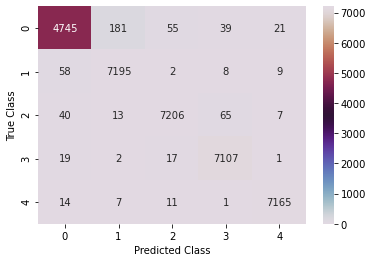

In [211]:
cm = confusion_matrix(y_test,prediction_bl)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [212]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.99547449 0.99240156 0.99681134 0.99579018 0.99858156]
Specificity Mean: 0.9958118257883415
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.94128149 0.98941144 0.98294912 0.9945424  0.99541539]
Recall/Sensitivity Mean: 0.9807199695188797
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.97313372 0.97256015 0.98834179 0.98434903 0.99472442]
Precision Mean: 0.9826218219307705


## Visualize training and test histories

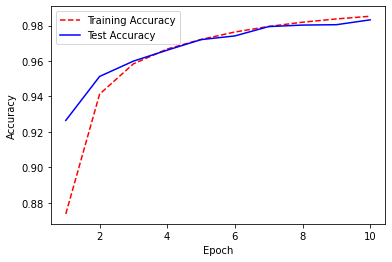

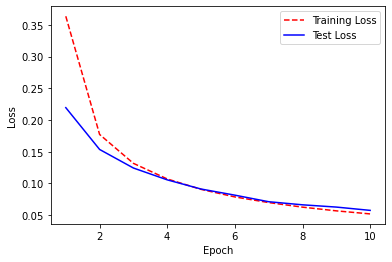

In [213]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification NN

In [214]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.999155 (macro),
0.999221 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999197 (macro),
0.999320 (weighted by prevalence)


## ROC Plot

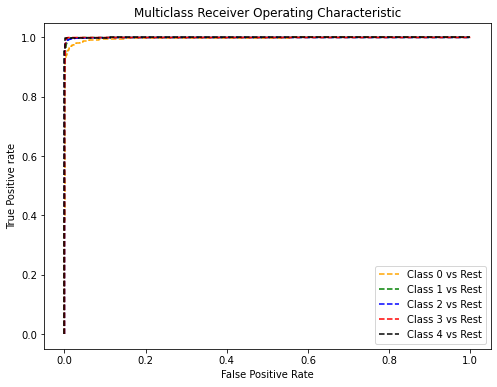

In [215]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


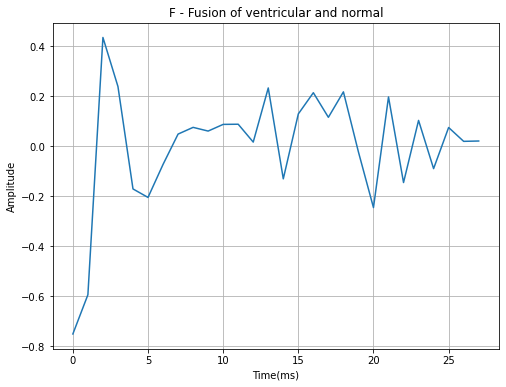

In [217]:
# Predict and plot example
print('The predicted class of the ECG sample is:', prediction_bl[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8])
Classes = class_label[y_test[8]]
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.title(Classes)
plt.grid()
plt.show()

# Increased model complexity
#### Added an extra layer with 64 units, Dropout of .20    


## Neural Net (Imbalanced and no PCA)

In [82]:
batch_size = 320 #850
num_classes = 5 
epochs = 10
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10,restore_best_weights=True,
 verbose=1)

def create_cplx():
    
    #Create model
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(n_cols,))) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.20)) 
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model
   

model = create_cplx()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               96256     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 129,413
Trainable params: 129,413
Non-trainable params: 0
_________________________________________________________________


In [83]:
#evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_cplx, 
                           epochs=epochs, batch_size=batch_size, 
                           verbose=1)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

Epoch 1/10
59097/59097 [==============================] - 3s 46us/step - loss: 0.4339 - accuracy: 0.8831
Epoch 2/10
59097/59097 [==============================] - 2s 37us/step - loss: 0.2323 - accuracy: 0.9360
Epoch 3/10
59097/59097 [==============================] - 3s 43us/step - loss: 0.1828 - accuracy: 0.9497
Epoch 4/10
59097/59097 [==============================] - 3s 44us/step - loss: 0.1549 - accuracy: 0.9577
Epoch 5/10
59097/59097 [==============================] - 3s 46us/step - loss: 0.1396 - accuracy: 0.9618
Epoch 6/10
59097/59097 [==============================] - 3s 46us/step - loss: 0.1239 - accuracy: 0.9654
Epoch 7/10
59097/59097 [==============================] - 3s 44us/step - loss: 0.1153 - accuracy: 0.9682
Epoch 8/10
59097/59097 [==============================] - 3s 44us/step - loss: 0.1091 - accuracy: 0.9691
Epoch 9/10
59097/59097 [==============================] - 3s 45us/step - loss: 0.0996 - accuracy: 0.9723
Epoch 10/10
19700/19700 [==============================

In [84]:
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 97.22% (0.09%)


In [85]:
history = model.fit(X_train, y_train, 
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[es],
                  verbose=1,
                  validation_data=(X_test, y_test))

Train on 78797 samples, validate on 8756 samples
Epoch 1/10
78797/78797 [==============================] - 4s 47us/step - loss: 0.3482 - accuracy: 0.9031 - val_loss: 0.1907 - val_accuracy: 0.9450
Epoch 2/10
78797/78797 [==============================] - 4s 50us/step - loss: 0.1867 - accuracy: 0.9484 - val_loss: 0.1454 - val_accuracy: 0.9606
Epoch 3/10
78797/78797 [==============================] - 4s 50us/step - loss: 0.1488 - accuracy: 0.9591 - val_loss: 0.1396 - val_accuracy: 0.9585
Epoch 4/10
78797/78797 [==============================] - 4s 47us/step - loss: 0.1290 - accuracy: 0.9643 - val_loss: 0.1059 - val_accuracy: 0.9716
Epoch 5/10
78797/78797 [==============================] - 4s 47us/step - loss: 0.1160 - accuracy: 0.9682 - val_loss: 0.1047 - val_accuracy: 0.9700
Epoch 6/10
78797/78797 [==============================] - 4s 47us/step - loss: 0.1057 - accuracy: 0.9710 - val_loss: 0.0909 - val_accuracy: 0.9749
Epoch 7/10
78797/78797 [==============================] - 4s 50us/ste

In [94]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)
prediction_cplx = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               96256     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 129,413
Trainable params: 129,413
Non-trainable params: 0
_________________________________________________________________
None
train samples: 78797
test samples: 8756
Test loss: 0.08310051096025506
Test accuracy: 0.9762448668479919


In [87]:
print(classification_report(y_test.astype(int), prediction_cplx))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7308
           1       0.95      0.69      0.80       196
           2       0.92      0.91      0.92       578
           3       0.93      0.55      0.69        51
           4       0.95      0.98      0.97       623

    accuracy                           0.98      8756
   macro avg       0.95      0.83      0.87      8756
weighted avg       0.98      0.98      0.98      8756



Text(0.5, 15.0, 'Predicted Class')

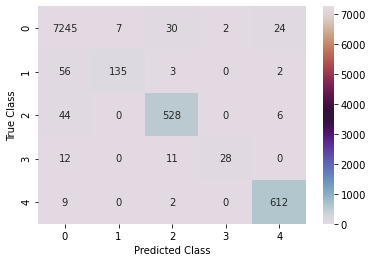

In [88]:
cm = confusion_matrix(y_test,prediction_cplx)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [89]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.91643646 0.99918224 0.99437515 0.99977025 0.99606541]
Specificity Mean: 0.9811659038859115
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.99137931 0.68877551 0.91349481 0.54901961 0.9823435 ]
Recall/Sensitivity Mean: 0.825002547455612
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.98357317 0.95070423 0.91986063 0.93333333 0.95031056]
Precision Mean: 0.9475563837824514


## Visualize training and test histories

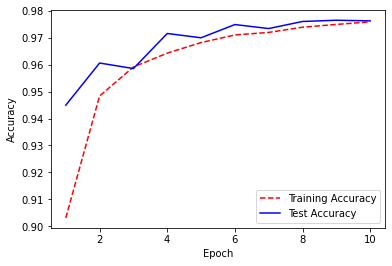

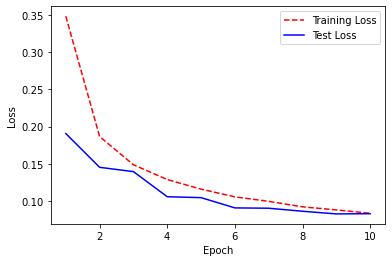

In [90]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification model

In [91]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.985129 (macro),
0.986489 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.988818 (macro),
0.992898 (weighted by prevalence)


### ROC plot

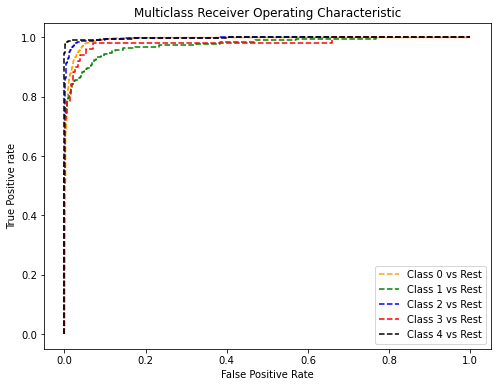

In [92]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 2
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


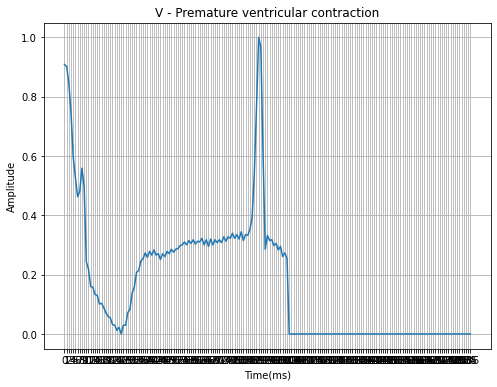

In [99]:
# Predict and plot example
print('The predicted class of the ECG sample is:', prediction_cplx[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

## Neural Network  (Balanced and with no PCA)

In [108]:
batch_size = 320 #850
num_classes = 5 
epochs = 10
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10,restore_best_weights=True,
 verbose=1)

def create_cplx():
    
    #Create model
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(n_cols,))) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.20)) 
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model
   

model = create_cplx()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               96256     
_________________________________________________________________
dense_29 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 325       
Total params: 129,413
Trainable params: 129,413
Non-trainable params: 0
_________________________________________________________________


In [68]:
#evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_cplx, 
                           epochs=epochs, batch_size=batch_size, 
                           verbose=1)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

Epoch 1/10
229419/229419 [==============================] - 13s 59us/step - loss: 0.3711 - accuracy: 0.8664
Epoch 2/10
229419/229419 [==============================] - 11s 47us/step - loss: 0.1681 - accuracy: 0.9417
Epoch 3/10
229419/229419 [==============================] - 10s 45us/step - loss: 0.1176 - accuracy: 0.9606
Epoch 4/10
229419/229419 [==============================] - 10s 44us/step - loss: 0.0901 - accuracy: 0.9702
Epoch 5/10
229419/229419 [==============================] - 10s 43us/step - loss: 0.0748 - accuracy: 0.9754
Epoch 6/10
229419/229419 [==============================] - 10s 44us/step - loss: 0.0623 - accuracy: 0.9796
Epoch 7/10
229419/229419 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.98 - 10s 45us/step - loss: 0.0547 - accuracy: 0.9823
Epoch 8/10
229419/229419 [==============================] - 10s 45us/step - loss: 0.0493 - accuracy: 0.9841
Epoch 9/10
229419/229419 [==============================] - 11s 47us/step - loss: 0.0425 - acc

In [69]:
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 98.88% (0.20%)


In [109]:
history = model.fit(X_train, y_train, 
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[es],
                  verbose=1,
                  validation_data=(X_test, y_test))

Train on 305892 samples, validate on 33988 samples
Epoch 1/10
305892/305892 [==============================] - 15s 48us/step - loss: 0.3148 - accuracy: 0.8871 - val_loss: 0.1548 - val_accuracy: 0.9458
Epoch 2/10
305892/305892 [==============================] - 16s 51us/step - loss: 0.1322 - accuracy: 0.9551 - val_loss: 0.0997 - val_accuracy: 0.9666
Epoch 3/10
305892/305892 [==============================] - 15s 48us/step - loss: 0.0904 - accuracy: 0.9703 - val_loss: 0.0748 - val_accuracy: 0.9743
Epoch 4/10
305892/305892 [==============================] - 15s 49us/step - loss: 0.0698 - accuracy: 0.9772 - val_loss: 0.0640 - val_accuracy: 0.9782
Epoch 5/10
305892/305892 [==============================] - 15s 48us/step - loss: 0.0562 - accuracy: 0.9820 - val_loss: 0.0519 - val_accuracy: 0.9831
Epoch 6/10
305892/305892 [==============================] - 15s 48us/step - loss: 0.0486 - accuracy: 0.9843 - val_loss: 0.0449 - val_accuracy: 0.9856
Epoch 7/10
305892/305892 [=======================

In [110]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)
prediction_cplx = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               96256     
_________________________________________________________________
dense_29 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 325       
Total params: 129,413
Trainable params: 129,413
Non-trainable params: 0
_________________________________________________________________
None
train samples: 305892
test samples: 33988
Test loss: 0.0328699065437667
Test accuracy: 0.9882017374038696


In [111]:
print(classification_report(y_test.astype(int), prediction_cplx))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      5041
           1       0.97      1.00      0.99      7272
           2       0.99      0.99      0.99      7331
           3       0.99      1.00      0.99      7146
           4       1.00      1.00      1.00      7198

    accuracy                           0.99     33988
   macro avg       0.99      0.99      0.99     33988
weighted avg       0.99      0.99      0.99     33988



Text(0.5, 15.0, 'Predicted Class')

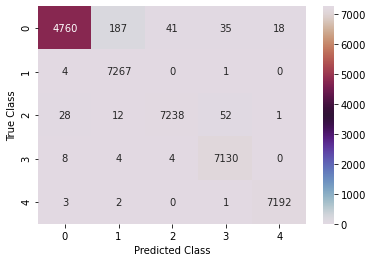

In [112]:
cm = confusion_matrix(y_test,prediction_cplx)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [113]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.99851453 0.9923267  0.99831189 0.9966843  0.99929078]
Specificity Mean: 0.9970256382171299
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.94425709 0.99931243 0.98731415 0.99776099 0.99916644]
Recall/Sensitivity Mean: 0.9855622177574554
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.99104726 0.97256424 0.99382123 0.98767142 0.99736514]
Precision Mean: 0.9884938577408487


## Visualize training and test histories

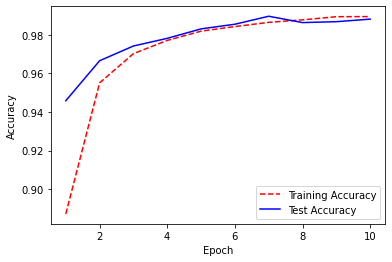

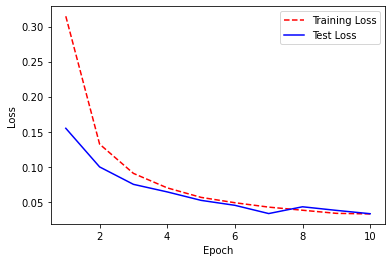

In [114]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification model

In [115]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.999717 (macro),
0.999739 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999732 (macro),
0.999774 (weighted by prevalence)


### ROC plot

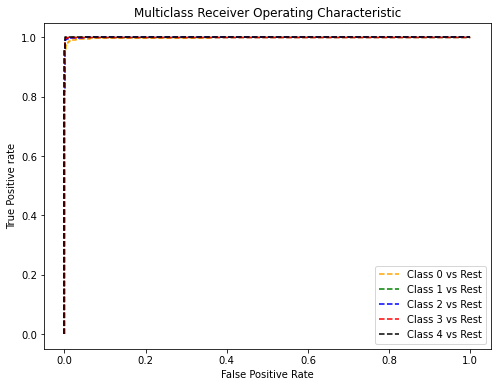

In [116]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: [1.6348733e-02 3.5626691e-08 7.9189789e-07 9.8365051e-01 2.0543363e-10]
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


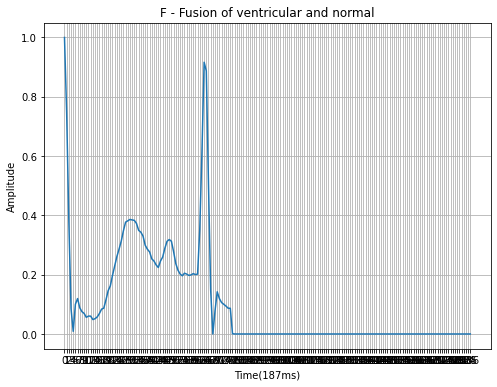

In [117]:
# Predict and plot example
print('The predicted class of the ECG sample is:', prediction_cplx[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(187ms)')
plt.grid()
plt.show()

## Neural Network  (Balanced and PCA)

In [218]:
batch_size = 320 #850
num_classes = 5 
epochs = 10
es = EarlyStopping(monitor='val_loss', mode='auto', patience=10,restore_best_weights=True,
 verbose=1)

def create_cplx():
    
    #Create model
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(n_cols,))) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.20)) 
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model
   

model = create_cplx()
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_42 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 325       
Total params: 48,005
Trainable params: 48,005
Non-trainable params: 0
_________________________________________________________________


In [219]:
#evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_cplx, 
                           epochs=epochs, batch_size=batch_size, 
                           verbose=1)

kfold = StratifiedKFold(n_splits=4, shuffle=True)

results = cross_val_score(estimator, X_train, y_train, cv=kfold)

Epoch 1/10
229419/229419 [==============================] - 5s 21us/step - loss: 0.3257 - accuracy: 0.8859
Epoch 2/10
229419/229419 [==============================] - 6s 26us/step - loss: 0.1396 - accuracy: 0.9539
Epoch 3/10
229419/229419 [==============================] - 6s 25us/step - loss: 0.0983 - accuracy: 0.9678
Epoch 4/10
229419/229419 [==============================] - 6s 25us/step - loss: 0.0776 - accuracy: 0.9746
Epoch 5/10
229419/229419 [==============================] - 6s 25us/step - loss: 0.0645 - accuracy: 0.9797
Epoch 6/10
229419/229419 [==============================] - 6s 25us/step - loss: 0.0544 - accuracy: 0.9829 0s - l
Epoch 7/10
229419/229419 [==============================] - 6s 25us/step - loss: 0.0480 - accuracy: 0.9850
Epoch 8/10
229419/229419 [==============================] - 6s 24us/step - loss: 0.0432 - accuracy: 0.9861
Epoch 9/10
229419/229419 [==============================] - 5s 24us/step - loss: 0.0384 - accuracy: 0.9876
Epoch 10/10
76473/76473 [=====

In [220]:
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 98.99% (0.09%)


In [221]:
history = model.fit(X_train, y_train, 
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=[es],
                  verbose=1,
                  validation_data=(X_test, y_test))

Train on 305892 samples, validate on 33988 samples
Epoch 1/10
305892/305892 [==============================] - 8s 28us/step - loss: 0.2836 - accuracy: 0.9011 - val_loss: 0.1387 - val_accuracy: 0.9533
Epoch 2/10
305892/305892 [==============================] - 8s 27us/step - loss: 0.1159 - accuracy: 0.9614 - val_loss: 0.0891 - val_accuracy: 0.9696
Epoch 3/10
305892/305892 [==============================] - 8s 28us/step - loss: 0.0800 - accuracy: 0.9737 - val_loss: 0.0634 - val_accuracy: 0.9791
Epoch 4/10
305892/305892 [==============================] - 8s 25us/step - loss: 0.0619 - accuracy: 0.9798 - val_loss: 0.0551 - val_accuracy: 0.9823
Epoch 5/10
305892/305892 [==============================] - 8s 26us/step - loss: 0.0508 - accuracy: 0.9837 - val_loss: 0.0541 - val_accuracy: 0.9832
Epoch 6/10
305892/305892 [==============================] - 8s 25us/step - loss: 0.0437 - accuracy: 0.9860 - val_loss: 0.0464 - val_accuracy: 0.9852
Epoch 7/10
305892/305892 [=============================

In [222]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)
prediction_cplx = model.predict_classes(X_test)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_42 (Dense)             (None, 64)                32832     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 5)                 325       
Total params: 48,005
Trainable params: 48,005
Non-trainable params: 0
_________________________________________________________________
None
train samples: 305892
test samples: 33988
Test loss: 0.028985753844545187
Test accuracy: 0.9912322163581848


In [223]:
print(classification_report(y_test.astype(int), prediction_cplx))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      5041
           1       0.99      0.99      0.99      7272
           2       0.99      0.99      0.99      7331
           3       0.99      1.00      1.00      7146
           4       1.00      1.00      1.00      7198

    accuracy                           0.99     33988
   macro avg       0.99      0.99      0.99     33988
weighted avg       0.99      0.99      0.99     33988



Text(0.5, 15.0, 'Predicted Class')

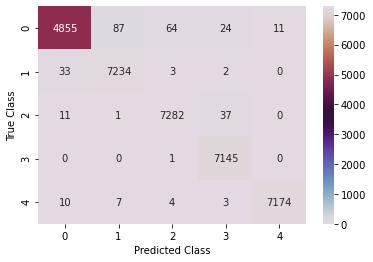

In [224]:
cm = confusion_matrix(y_test,prediction_cplx)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [225]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.99813452 0.99644408 0.99729902 0.99754117 0.9995894 ]
Specificity Mean: 0.9978016373839242
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.96310256 0.99477448 0.99331606 0.99986006 0.99666574]
Recall/Sensitivity Mean: 0.9895437787257265
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.9889998  0.9870378  0.99020941 0.99084732 0.99846903]
Precision Mean: 0.9911126701009783


## Visualize training and test histories

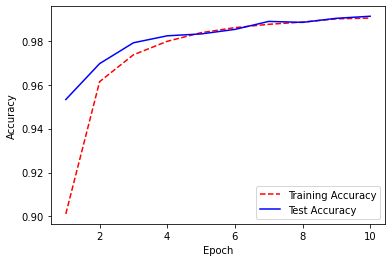

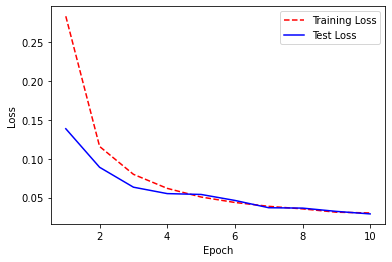

In [226]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### ROC scores for multi-class classification model

In [227]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict_proba(X_test)

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.999608 (macro),
0.999643 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999631 (macro),
0.999696 (weighted by prevalence)


### ROC plot

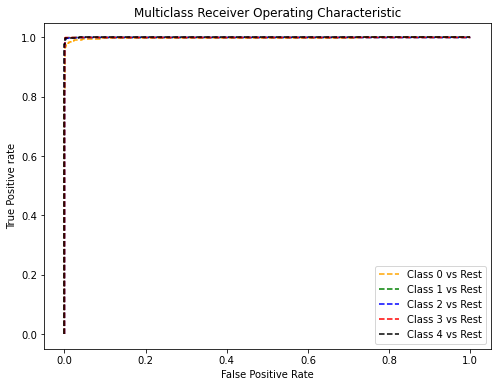

In [228]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Predict a single ECG sample and plot the selection

The predicted class of the ECG sample is: 3
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


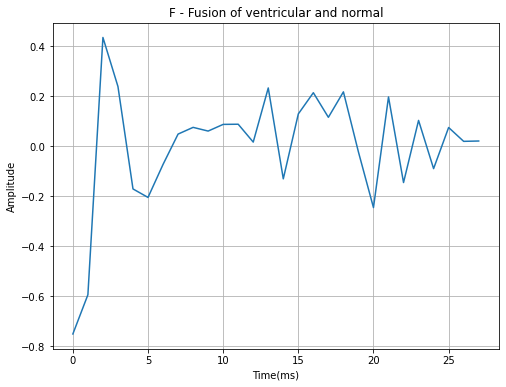

In [229]:
# Predict and plot example
prediction_cplx = model.predict_classes(X_test)
print('The predicted class of the ECG sample is:', prediction_cplx[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8])
Classes = class_label[y_test[8]]
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.title(Classes)
plt.grid()
plt.show()

# Sequence Learning
* Stacked 1D convolutional layer, three LSTM's, Dense Softmax output.

### Dependencies

In [277]:
# imports
import numpy as np
import pandas as pd
#!pip install pandas-profiling
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
import graphviz
%matplotlib inline

np.random.seed(123)

#!pip install scikit-learn
import sklearn
import scikitplot as skplt
import sklearn.feature_selection
from sklearn.preprocessing import label_binarize,OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [278]:
import tensorflow as tf
import keras
from keras.utils import plot_model
from keras import regularizers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D,MaxPooling1D,AveragePooling1D
from keras.models import Sequential, load_model
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

## Data

In [279]:
# Download dataset
data_ecg = pd.read_csv('data_ecg.csv')
data_ecg.head(2)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,label
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [280]:
#Split features and targets and make copy of df
X = data_ecg.drop('label',axis=1).copy() 
y = data_ecg['label'].copy()

In [281]:
import imblearn
from collections import Counter
print(imblearn.__version__)
counter = Counter(y)
print(counter)

0.7.0
Counter({0.0: 72470, 4.0: 6431, 2.0: 5788, 1.0: 2223, 3.0: 641})


In [282]:
#Class distributions
import matplotlib.pyplot as pyplot
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=72470 (82.773%)
Class=1, n=2223 (2.539%)
Class=2, n=5788 (6.611%)
Class=3, n=641 (0.732%)
Class=4, n=6431 (7.345%)


## Class Labels

In [283]:
# For class label mapping

class_label = {
    0: 'N - Normal',
    1: 'S - Atrial premature',
    2: 'V - Premature ventricular contraction',
    3: 'F - Fusion of ventricular and normal',
    4: 'Q - Paced Unclassifiable'
}

# Train_Test_Split

In [284]:
# Using 90% for training and 10% for testing
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y,train_size=0.9,random_state=0)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [285]:
#Transform the dataset into arrays
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [286]:
X_train.shape

(78797, 187)

In [287]:
unique_classes = np.unique(y_train)
unique_classes

array([0, 1, 2, 3, 4], dtype=int64)

# Model Definition

In [314]:

inputs = tf.keras.Input(shape=(X_train.shape[1],))
expand = tf.expand_dims(inputs, axis=2)

conv1 = tf.keras.layers.Conv1D(filters=10,
               kernel_size=10,
               strides=1,
               activation='relu',
               padding='same')(expand)

conv1 = tf.keras.layers.BatchNormalization()(conv1)
conv1 = tf.keras.layers.MaxPooling1D(18)(conv1)

lstm1 = tf.keras.layers.LSTM(100,activation='relu', return_sequences=True, dropout=0.1,recurrent_dropout=0.1,unit_forget_bias=True)(conv1)
lstm1 = tf.keras.layers.BatchNormalization()(lstm1)

lstm2 = tf.keras.layers.LSTM(100,activation='relu', return_sequences=True, dropout=0.1,recurrent_dropout=0.1,unit_forget_bias=True)(lstm1)
lstm2 = tf.keras.layers.BatchNormalization()(lstm2)

lstm3 = tf.keras.layers.LSTM(100,activation='relu', dropout=0.1,recurrent_dropout=0.1,unit_forget_bias=True)(lstm2)
lstm3 = tf.keras.layers.BatchNormalization()(lstm3)


flatten = tf.keras.layers.Flatten()(lstm3) 

outputs = tf.keras.layers.Dense(5, activation='softmax')(flatten)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

#img_file = './model_ecg.png'
#tf.keras.utils.plot_model(model, to_file=img_file, show_layer_names=True, show_shapes=True)

# See model_arch.png

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 187)]             0         
_________________________________________________________________
tf_op_layer_ExpandDims_19 (T [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 187, 10)           110       
_________________________________________________________________
batch_normalization_76 (Batc (None, 187, 10)           40        
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 10, 10)            0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 10, 100)           44400     
_________________________________________________________________
batch_normalization_77 (Batc (None, 10, 100)           400

In [289]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#RMSprop optimizer
#adam opt., nadam

In [290]:
epochs = 10
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=500,
                    verbose=2,
                    validation_split = 0.15)

Train on 66977 samples, validate on 11820 samples
Epoch 1/10
66977/66977 - 82s - loss: 0.6027 - accuracy: 0.8449 - val_loss: 0.6919 - val_accuracy: 0.8232
Epoch 2/10
66977/66977 - 63s - loss: 0.2139 - accuracy: 0.9405 - val_loss: 0.6666 - val_accuracy: 0.8232
Epoch 3/10
66977/66977 - 60s - loss: 0.1702 - accuracy: 0.9520 - val_loss: 0.9483 - val_accuracy: 0.6113
Epoch 4/10
66977/66977 - 61s - loss: 0.1467 - accuracy: 0.9588 - val_loss: 1.1532 - val_accuracy: 0.5855
Epoch 5/10
66977/66977 - 60s - loss: 0.1319 - accuracy: 0.9624 - val_loss: 0.3307 - val_accuracy: 0.8933
Epoch 6/10
66977/66977 - 62s - loss: 0.1214 - accuracy: 0.9653 - val_loss: 0.1108 - val_accuracy: 0.9685
Epoch 7/10
66977/66977 - 60s - loss: 0.1081 - accuracy: 0.9688 - val_loss: 0.1044 - val_accuracy: 0.9719
Epoch 8/10
66977/66977 - 61s - loss: 0.1056 - accuracy: 0.9692 - val_loss: 0.0962 - val_accuracy: 0.9729
Epoch 9/10
66977/66977 - 62s - loss: 0.0996 - accuracy: 0.9710 - val_loss: 0.0948 - val_accuracy: 0.9723
Epoch

In [291]:
# Print model fitting summury 
score = model.evaluate(X_test, y_test, verbose=0)
prediction_cplx = model.predict(X_test).argmax(axis=1)

print(model.summary())
print('train samples:', X_train.shape[0])
print('test samples:', X_test.shape[0])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 187)]             0         
_________________________________________________________________
tf_op_layer_ExpandDims_17 (T [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 187, 10)           110       
_________________________________________________________________
batch_normalization_68 (Batc (None, 187, 10)           40        
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 10, 10)            0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 10, 100)           44400     
_________________________________________________________________
batch_normalization_69 (Batc (None, 10, 100)           400

In [292]:
# Classification report
print(classification_report(y_test.astype(int), prediction_cplx))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7308
           1       0.96      0.69      0.81       196
           2       0.95      0.91      0.93       578
           3       0.82      0.71      0.76        51
           4       0.99      0.97      0.98       623

    accuracy                           0.98      8756
   macro avg       0.94      0.86      0.89      8756
weighted avg       0.98      0.98      0.98      8756



Text(0.5, 15.0, 'Predicted Class')

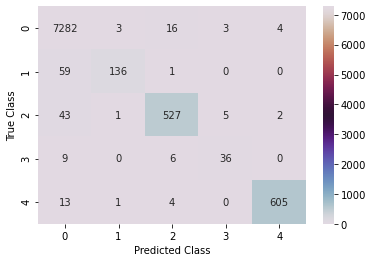

In [293]:
cm = confusion_matrix(y_test,prediction_cplx)
#plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=True, cmap='twilight')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [294]:
#Performance metrics from confusion matrix 

FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, Recall, or true positive rate
TPR = TP/(TP+FN)

# Specificity or true negative rate
TNR = TN/(TN+FP) 

# Precision or positive predictive value
PPV = TP/(TP+FP)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)


print('Class:',class_label)

print('Specificity:',TNR)
print('Specificity Mean:',TNR.mean())

print('Class:',class_label)

print('Recall/Sensitivity:',TPR)
print('Recall/Sensitivity Mean:',TPR.mean())

print('Class:',class_label)

print('Precision:',PPV)
print('Precision Mean:',PPV.mean())

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Specificity: [0.91436464 0.99941589 0.99669846 0.99908099 0.99926226]
Specificity Mean: 0.9817644481600659
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Recall/Sensitivity: [0.99644226 0.69387755 0.91176471 0.70588235 0.97110754]
Recall/Sensitivity Mean: 0.855814881809627
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
Precision: [0.98325682 0.96453901 0.95126354 0.81818182 0.99018003]
Precision Mean: 0.9414842429417899


### ROC scores

In [295]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


#y_prob = classifier.predict_proba(X_test)

prediction_cplx = model.predict(X_test)#.argmax(axis=1) #_proba

macro_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test, prediction_cplx, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test, prediction_cplx, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

One-vs-One ROC AUC scores:
0.991086 (macro),
0.991111 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.992509 (macro),
0.994910 (weighted by prevalence)


## ROC plots

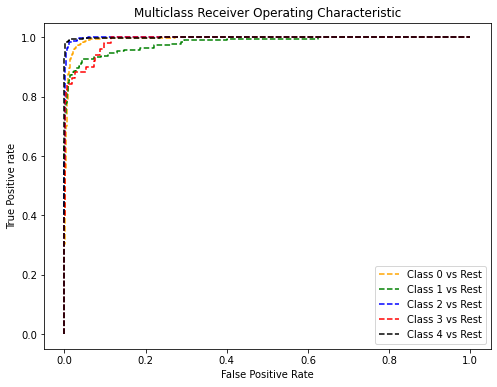

In [296]:
#ROC for multi-class classification model, balanced data (SMOTE)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

prediction_cplx = model.predict(X_test) #_proba

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prediction_cplx[:,i], pos_label=i)
    
# plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
#plt.plot(fpr[5], tpr[5], linestyle='--',color='purple', label='Class 5 vs Rest')
#plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='Class 6 vs Rest')
plt.title('Multiclass Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Plot train and test accuracy and loss

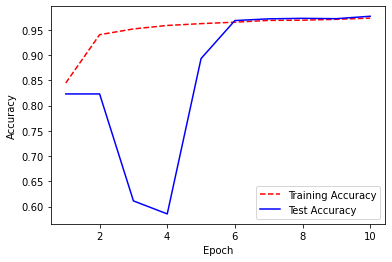

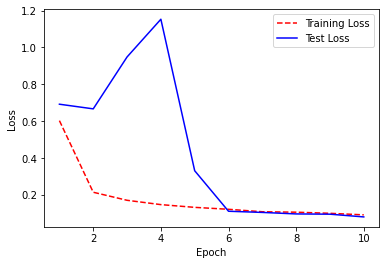

In [297]:
#Get training and test accuracy histories
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

#Epoch count
epoch_count = range(1,len(training_accuracy) + 1)

#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count,test_accuracy, "b-")
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

#Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']


#Epoch count
epoch_count = range(1,len(training_loss) + 1)

#Visualize loss history
#plt.figure(figsize=(8, 6))
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count,test_loss, "b-")
plt.legend(['Training Loss','Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Predict and plot a single ECG sample

The predicted class of the ECG sample is: 2
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


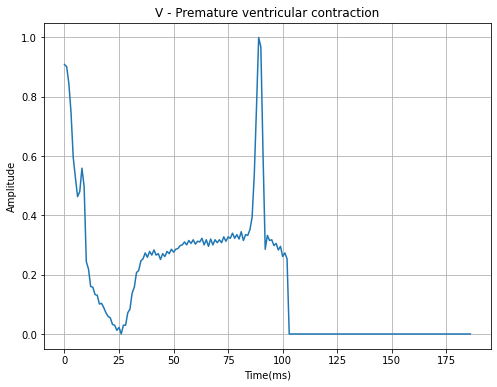

In [298]:
# Predict and plot example

prediction_cplx = model.predict(X_test).argmax(axis=1)
print('The predicted class of the ECG sample is:', prediction_cplx[8])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8])
Classes = class_label[y_test[8]]
plt.xlabel('Time(ms)')
plt.ylabel('Amplitude')
plt.title(Classes)
plt.grid()
plt.show()

The predicted class of the ECG sample is: 0
Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}


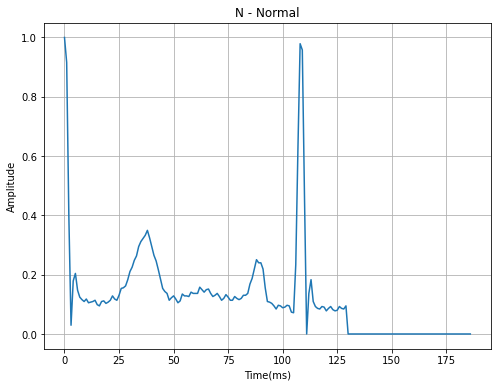

In [312]:
# Predict and plot example

prediction_cplx = model.predict(X_test).argmax(axis=1)
print('The predicted class of the ECG sample is:', prediction_cplx[18])
print('Class:',class_label)

plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[18:19].T)
Classes = class_label[y_test[18]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Amplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

## Save Sequence model as: ECG_1DL3.h5

In [299]:
model.save('ECG_1DL3.h5')

In [301]:
# Sanity check
ECG_1DL3 = tf.keras.models.load_model('ECG_1DL3.h5')
ECG_1DL3.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 187)]             0         
_________________________________________________________________
tf_op_layer_ExpandDims_17 (T (None, 187, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 187, 10)           110       
_________________________________________________________________
batch_normalization_68 (Batc (None, 187, 10)           40        
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 10, 10)            0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 10, 100)           44400     
_________________________________________________________________
batch_normalization_69 (Batc (None, 10, 100)           400

# Save best Non-Time Series model

### Save the best random forest model to pickle file

In [110]:
# Best random forest model(Balanced data; no PCA)
filename = 'ECG_rf.pkl'
pickle.dump(rf, open(filename,'wb'))

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
The prediction is class: [2]


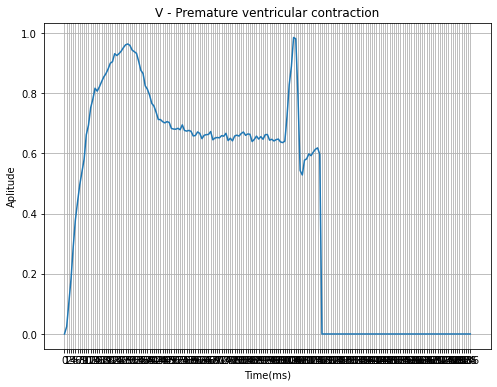

In [111]:
# Sanity Check
# Load model
ECG_rf = pickle.load(open(filename,'rb'))

# Make a prediction
print('Class:',class_label)
print('The prediction is class:', ECG_rf.predict(X_test[11:12]))

# Plot the predicted sample
plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[11:12].T)
Classes = class_label[y_test[11]]
plt.title(Classes)
plt.ylabel('Aplitude')
plt.xlabel('Time(ms)')
plt.grid()
plt.show()

### Save best random forest model using joblib

In [92]:
# Best random forest model (Balanced data; no PCA)
joblib.dump(rf, './ECG_rf_2.joblib')

['./ECG_rf_2.joblib']

Class: {0: 'N - Normal', 1: 'S - Atrial premature', 2: 'V - Premature ventricular contraction', 3: 'F - Fusion of ventricular and normal', 4: 'Q - Paced Unclassifiable'}
The prediction is class: [3]


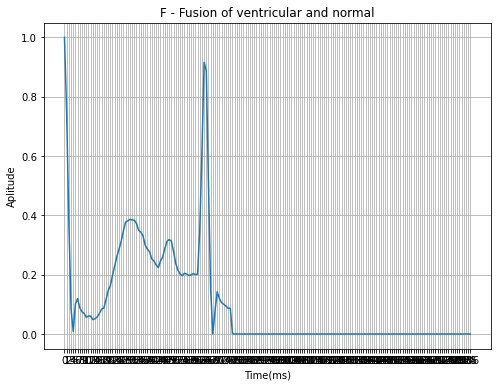

In [93]:
# Sanity Check
# Load the model
ECG_rf_2 = joblib.load("./ECG_rf_2.joblib")

# Make a prediction
print('Class:',class_label)
print('The prediction is class:',ECG_rf_2.predict(X_test[8:9]))

# Plot the predicted sample
plt.figure(figsize=(8.0,6.0))
plt.plot(X_test[8:9].T)
Classes = class_label[y_test[8]]
plt.title(Classes)
#plt.xticks(rotation=90)
plt.ylabel('Aplitude')
plt.xlabel('Time(ms)')#Note: Time(187(ms))without pca
plt.grid()
plt.show()